In [1]:
%matplotlib inline
from dolfin import *
from mshr import *
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
import logging
logging.getLogger("FFC").setLevel(logging.WARNING)

set_log_active(False)
dolfin.parameters.reorder_dofs_serial = False

In [2]:
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))
# end of commands for plotting

In [3]:
s = 2
thetaS = 0.2
#THIS SECTION IS FOR MAKING THE MESH

r1 = 1 #radius of cylinder
r2 = 10 #radius of bounding circle 
nr = 20 #number of radial divisions
nt = 50 #number of theta divisions 
mesh = RectangleMesh(Point(r1, 0), Point(r2, 1), nr, nt, "crossed")

x = mesh.coordinates()[:,0]
y = mesh.coordinates()[:,1]

def denser(x,y):
	return [r1 + (r2-r1)*((x-r1)/(r2-r1))**s, y]

x_bar, y_bar = denser(x, y)
xy_bar_coor = np.array([x_bar,y_bar]).transpose()
mesh.coordinates()[:] = xy_bar_coor

def cylinder(r, s, Theta):
	return [r*np.cos(Theta*s), r*np.sin(Theta*s)]

x_hat, y_hat = cylinder(x_bar, y_bar,2*np.pi)
xy_hat_coor = np.array([x_hat,y_hat]).transpose()
mesh.coordinates()[:] = xy_hat_coor

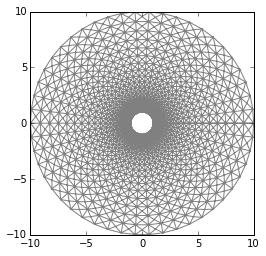

In [4]:
plot(mesh)

In [5]:
#THIS SECTION IS FOR MARKING BOUNDARIES OF THE MESH
class outer_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - r2) < tol

class inner_boundary(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return on_boundary and abs(r - r1) < tol

class half_circleX(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		return on_boundary and abs(x[1]) < tol

class half_circleY(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-1
		return on_boundary and abs(x[0]) < tol

outerradius = outer_boundary()
innerradius = inner_boundary()
half_circleX = half_circleX()
half_circleY = half_circleY()

boundaries = FacetFunction("size_t", mesh)

boundaries.set_all(0)
innerradius.mark(boundaries,1)
outerradius.mark(boundaries,2)
half_circleX.mark(boundaries,3)
half_circleY.mark(boundaries,4)

In [6]:
#This section defines the finite element basis functions
V = FunctionSpace(mesh,'Lagrange',1)
nx = TrialFunction(V)
ny = TrialFunction(V)
v1 = TestFunction(V)
v2 = TestFunction(V)

In [7]:
#Boundary Conditions
gx = Expression('-x[1]*sin(ThetaInner)/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = thetaS) 
gy = Expression('x[0]*sin(ThetaInner)/sqrt(x[0]*x[0] + x[1]*x[1])',ThetaInner = thetaS)

#For nx
bcs1 = [DirichletBC(V, 0, boundaries, 2),
	   DirichletBC(V, gx, boundaries, 1),
	   DirichletBC(V, 0, boundaries, 3)]
#for ny
bcs2 = [DirichletBC(V, 0, boundaries, 2),
		DirichletBC(V, gy, boundaries, 1),
		DirichletBC(V, 0, boundaries, 4)]

In [8]:
#Solving the problem
f = Constant(0.0)

a1 = inner(nabla_grad(nx), nabla_grad(v1))*dx
a2 = inner(nabla_grad(ny), nabla_grad(v2))*dx
L1 = f*v1*dx
L2 = f*v2*dx
nx = Function(V)
ny = Function(V)
solve(a1 == L1, nx, bcs1)
solve(a2 == L2, ny, bcs2)

V_d = VectorFunctionSpace(mesh,'Lagrange',1)
w1 = TrialFunction(V_d)
w2 = TrialFunction(V_d)
q1 = TestFunction(V_d)
q2 = TestFunction(V_d)

a3 = inner(w1,q1)*dx
a4 = inner(w2,q2)*dx
L3 = inner(grad(nx),q1)*dx
L4 = inner(grad(ny),q2)*dx
grad_nx = Function(V_d)
grad_ny = Function(V_d)
solve(a3 == L3, grad_nx)
solve(a4 == L4, grad_ny)

dxnx, dynx = grad_nx.split(deepcopy=True)
dxny, dyny = grad_ny.split(deepcopy=True)

In [9]:
#Finding the energies
class int_radius(SubDomain):
	def inside(self, x, on_boundary):
		tol = 1E-4
		r = sqrt(x[0]*x[0] + x[1]*x[1])
		return ((r - r1)> tol)

int_radius = int_radius()
cell_markers = CellFunction("uint", mesh)
cell_markers.set_all(0)
int_radius.mark(cell_markers,5)

dx1 = Measure("dx", domain=mesh, subdomain_data=cell_markers)

# quad = pow(dxnx+dyny,2)/2
# surf = pow(dxny-dynx,2)/2

quad = (1/2)*(pow(dxnx,2) + pow(dynx,2) + pow(dxny,2) + pow(dyny,2))
surf = ((dxnx*dyny) - (dxny*dynx))
Equad = assemble(quad*dx1(5))
Esurf = assemble(surf*dx1(5))

fel = quad + surf
Etot = Esurf+Equad

print("Quad Energy %f" % Equad)
print("Surf Energy %f" % Esurf)
print("Total Energy %f" % (Esurf + Equad))

Quad Energy 0.000000
Surf Energy -0.119909
Total Energy -0.119909


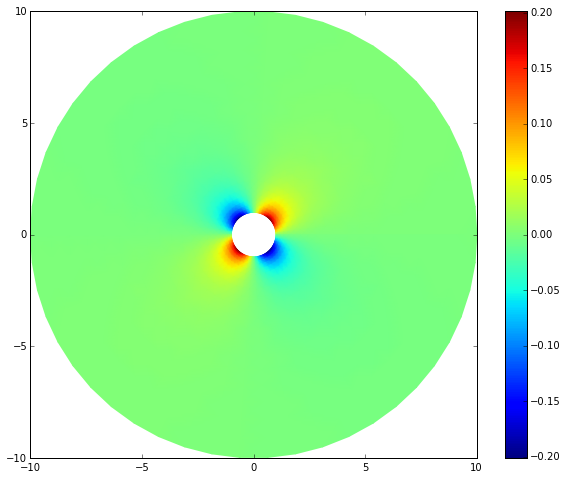

In [10]:
plt.figure(figsize=(10,10))
plot(dxnx)
plt.colorbar(shrink=0.8);

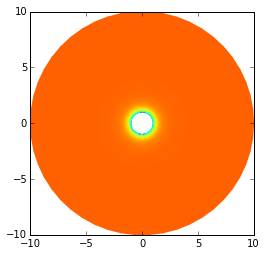

In [12]:
f = project(fel,V)
plot(f)